In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1).float())  # Flatten the images
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=10, shuffle=True)

100%|██████████| 9912422/9912422 [04:48<00:00, 34309.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 465281.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:51<00:00, 32200.69it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14291469.44it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class BoltzmannMachine(nn.Module):
    def __init__(self, num_visible, num_hidden):
        super(BoltzmannMachine, self).__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        U = torch.randn(num_visible, num_visible) * 0.01
        V = torch.randn(num_hidden, num_hidden) * 0.01
        self.U = nn.Parameter((U + U.t()) * 0.5)
        self.V = nn.Parameter((V + V.t()) * 0.5)
        self.U.data.fill_diagonal_(0)
        self.V.data.fill_diagonal_(0)

        self.W = nn.Parameter(torch.randn(num_visible, num_hidden) * 0.01)
        self.b_v = nn.Parameter(torch.zeros(num_visible))
        self.b_h = nn.Parameter(torch.zeros(num_hidden))

    def energy(self, v, h):
        # Calculate interactions within visible and hidden layers
        vv_interaction = torch.sum(torch.mm(v, self.U) * v, dim=1)
        hh_interaction = torch.sum(torch.mm(h, self.V) * h, dim=1)
        # Visible-to-hidden interactions
        vh_interaction = torch.mm(v, self.W) * h
        vbias_term = torch.matmul(v, self.b_v)
        hbias_term = torch.matmul(h, self.b_h)
        # Summing up the interactions and biases
        return -0.5 * (vv_interaction + hh_interaction) - vh_interaction.sum(dim=1) - vbias_term - hbias_term

    def sample_h(self, v):
        # Sample hidden states given visible states
        activation = torch.matmul(v, self.W) + self.b_h.expand_as(torch.matmul(v, self.W))
        prob_h = torch.sigmoid(activation)
        return torch.bernoulli(prob_h)

    def sample_v(self, h):
        # Sample visible states given hidden states
        activation = torch.matmul(h, self.W.t()) + self.b_v.expand_as(torch.matmul(h, self.W.t()))
        prob_v = torch.sigmoid(activation)
        return torch.bernoulli(prob_v)

    def gibbs_sampling(self, v0, steps=1):
        v = v0.clone()
        for _ in range(steps):
            h = self.sample_h(v)
            v = self.sample_v(h)
        return v, h

    def contrastive_divergence(self, v0, k=1):
        v, h = self.gibbs_sampling(v0, k)
        return v0, self.sample_h(v0), v, h

In [4]:
# Initialize the Boltzmann Machine
num_visible = 784  # MNIST images are 28x28
num_hidden = 64
bm = BoltzmannMachine(num_visible, num_hidden)

# Training hyperparameters
epochs = 5
learning_rate = 0.01
optimizer = torch.optim.SGD(bm.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0
    for i, (data, _) in enumerate(train_loader):
        v = data.view(-1, num_visible)  # Flatten the images
        # Perform one step of CD
        v0, h0, vk, hk = bm.contrastive_divergence(v)

        # Update weights and biases using CD-1
        optimizer.zero_grad()
        energy_v0_h0 = bm.energy(v0, h0)
        energy_vk_hk = bm.energy(vk, hk)
        loss = (energy_v0_h0 - energy_vk_hk).mean()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if i % 100 == 0:
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {loss.item()}')

    print(f'Epoch {epoch} completed. Average Loss: {epoch_loss / len(train_loader)}')

Epoch 1, Batch 1, Loss: -0.6038476228713989
Epoch 1, Batch 101, Loss: -2125.72021484375
Epoch 1, Batch 201, Loss: -3018.5
Epoch 1, Batch 301, Loss: -3901.682373046875
Epoch 1, Batch 401, Loss: -3745.212890625
Epoch 1, Batch 501, Loss: -4277.9873046875
Epoch 1, Batch 601, Loss: -3480.27685546875
Epoch 1, Batch 701, Loss: -3245.1298828125
Epoch 1, Batch 801, Loss: -2318.10693359375
Epoch 1, Batch 901, Loss: -3399.78076171875
Epoch 1, Batch 1001, Loss: -1945.874755859375
Epoch 1, Batch 1101, Loss: -2485.06689453125
Epoch 1, Batch 1201, Loss: -1780.8919677734375
Epoch 1, Batch 1301, Loss: -2078.096435546875
Epoch 1, Batch 1401, Loss: -1718.2064208984375
Epoch 1, Batch 1501, Loss: -2379.66015625
Epoch 1, Batch 1601, Loss: -2023.9951171875
Epoch 1, Batch 1701, Loss: -2384.109619140625
Epoch 1, Batch 1801, Loss: -1544.568115234375
Epoch 1, Batch 1901, Loss: -1189.0267333984375
Epoch 1, Batch 2001, Loss: -1441.6146240234375
Epoch 1, Batch 2101, Loss: -1664.043212890625
Epoch 1, Batch 2201, Los

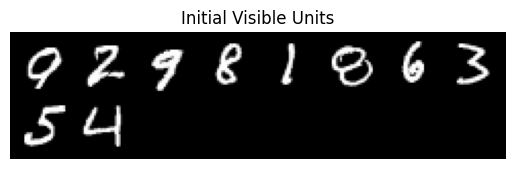

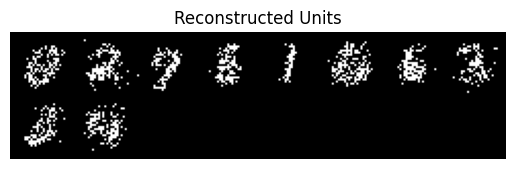

In [6]:
def show_and_save(file_name, img, title):
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    plt.imshow(npimg, cmap='gray')
    plt.title(title)
    plt.axis('off')
    f = f"./{file_name}.png"
    plt.imsave(f, npimg)
    plt.show()

show_and_save("initial_visible_units", make_grid(v0.view(-1, 1, 28, 28).data), "Initial Visible Units")

show_and_save("reconstructed_visible_units", make_grid(vk.view(-1, 1, 28, 28).data), "Reconstructed Units")